In [1]:
#data analysis libraries
import numpy as np
import pandas as pd

# machine learning
import sklearn

#graph deep learning
import torch
import torch_geometric
import networkx as nx
from d2l import torch as d2l

#visualization libraries
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch_geometric
%matplotlib inline

#ignore warnings
import warnings

warnings.filterwarnings('ignore')

# auto load change
%load_ext autoreload
%autoreload 2

# GNN + LSTM
**notice: train and predict all process in `graphlstm_vae_ad.py`**

## load data
metrics will be reshape like : **(num_timeseries, num_micorservice, performance_metrics)**

In [13]:
from util.clean_data import get_and_normalize_data

metrics = get_and_normalize_data('DatasetUpdate/MMS (1).csv')

In [14]:
from sklearn.model_selection import train_test_split

train, test = train_test_split(metrics, test_size=0.3, shuffle=False)

pod                               metric              
adservice-76469b5944-9tlwk        CpuUsage(m)             0
                                  MemoryUsage(Mi)         0
                                  NetworkReceiveBytes     0
                                  NetworkTransmitBytes    0
                                  PodLatency(s)           0
                                                         ..
shippingservice-7499794f94-s67q7  NetworkReceiveBytes     0
                                  NetworkTransmitBytes    0
                                  PodLatency(s)           0
                                  PodSuccessRate(%)       0
                                  PodWorkload(Ops)        0
Length: 350, dtype: int64

In [15]:
metrics

In [20]:
train

19

In [22]:
import pickle

with open('DatasetUpdate/MMS_topology.pk', 'rb') as f:
    edge_index = pickle.load(f)

In [25]:
from graph_lstm_vae_ad_ver6 import GraphLSTM_VAE_AD
def test_batch_independence():
    net = GraphLSTM_VAE_AD()

    outputs = net.fit(train, 50, edge_index)

    # Mask loss for certain samples in batch
    batch_size = train[0].shape[0]
    mask_idx = torch.randint(0, batch_size, ())
    mask = torch.ones_like(outputs)
    mask[mask_idx] = 0
    outputs = outputs * mask

    # Compute backward pass
    loss = outputs.mean()
    loss.backward()

    # Check if gradient exists and is zero for masked samples
    for i, grad in enumerate(train.grad):
        if i == mask_idx:
            assert torch.all(grad == 0).item()
        else:
            assert not torch.all(grad == 0)
test_batch_independence()

TimeStamp adservice-76469b5944-9tlwk                  \
       Unnamed: 0_level_1                CpuUsage(m) MemoryUsage(Mi)   
0     2020-04-02 14:45:00                   2.579968      145.703125   
1     2020-04-02 14:46:00                   2.563623      145.703125   
2     2020-04-02 14:47:00                   2.655893      145.703125   
3     2020-04-02 14:48:00                   2.659674      145.703125   
4     2020-04-02 14:49:00                   2.666432      145.703125   
...                   ...                        ...             ...   
4365  2020-04-05 16:07:00                   3.125695      138.441406   
4366  2020-04-05 16:08:00                        NaN             NaN   
4367  2020-04-05 16:09:00                   1.490589      138.503906   
4368  2020-04-05 16:10:00                   2.374731      138.441406   
4369  2020-04-05 16:11:00                   2.911970      138.441406   

                                                                 \
     NetworkReceiveBytes NetworkTransmitBytes PodSuccessRate(%)   
0            2109.643981         10315.049053         95.833333   
1            2081.221198          8537.689269         92.727273   
2            2216.787299          8086.154565         96.078431   
3            2085.443038          8053.409972         92.156863   
4            2397.958293          9436.523864         92.592593   
...                  ...                  ...               ...   
4365         6620.963686         20772.759280         99.043062   
4366                 NaN                  NaN               NaN   
4367         4879.333552         13900.432900         95.652174   
4368         5090.418062         14870.854488         95.541401   
4369         5219.939418         16393.256947         98.064516   

                      adservice-76469b5944-h6cqg                  \
     PodWorkload(Ops)                CpuUsage(m) MemoryUsage(Mi)   
0            3.199787                   2.333726      140.167969   
1            3.666667                   1.915617      140.160156   
2            3.400227                   2.219946      140.167969   
3            3.400000                   2.350126      140.167969   
4            3.602642                   2.393401      140.160156   
...               ...                        ...             ...   
4365        13.920341                        NaN             NaN   
4366              NaN                   3.051511      146.839844   
4367         9.200000                   2.024893      146.847656   
4368        10.461785                   2.714380      146.839844   
4369        10.333333                   2.007035      146.839844   

                          ... shippingservice-7499794f94-gmcld  \
     NetworkReceiveBytes  ...             NetworkTransmitBytes   
0            2035.099393  ...                      7772.816879   
1            2035.866717  ...                      7377.946267   
2            2003.811486  ...                      4599.361214   
3            2043.254466  ...                      6608.513608   
4            2130.156700  ...                      7770.101213   
...                  ...  ...                              ...   
4365                 NaN  ...                              NaN   
4366         6576.701210  ...                     17056.327922   
4367         4874.003820  ...                     14847.764072   
4368         5326.326895  ...                     10481.878662   
4369         5272.956327  ...                     13375.982510   

                                        shippingservice-7499794f94-s67q7  \
     PodSuccessRate(%) PodWorkload(Ops)                      CpuUsage(m)   
0                100.0         3.933071                         0.190951   
1                100.0         3.733333                         0.179055   
2                100.0         3.000200                         0.218627   
3                100.0         2.533333                         0.205551   
4      

## train
**only split train and test**

In [ ]:
from graph_lstm_vae_ad_ver6 import GraphLSTM_VAE_AD

lstm = GraphLSTM_VAE_AD(variational=False)
lstm.fit(train, 50, edge_index)

In [ ]:
scores_sum, scores_max, outputs = lstm.predict(test, 50, edge_index, 5)

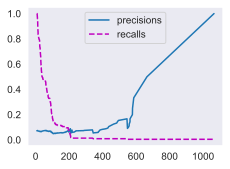

In [14]:
from sklearn.metrics import precision_recall_curve

df = pd.read_csv('DatasetUpdate/MMS (1).csv', header=[0, 1])
test_label = df[3059: 3059 + 1286]['label'].to_numpy()
precisions, recalls, thresholds = precision_recall_curve(test_label, scores_sum)

In [ ]:
d2l.plot(thresholds, [precisions[:-1], recalls[:-1]], legend=['precisions', 'recalls'])

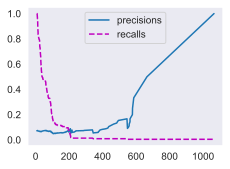

In [19]:
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(test_label, scores_sum)

In [ ]:
d2l.plot(fpr, tpr)